In [9]:
import os
import pandas as pd
import numpy as np
import torch
import random
import re
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from eunjeon import Mecab
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, f1_score

from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Bidirectional
from gensim.models import Word2Vec

plt.rc('font', family='Malgun Gothic')


In [10]:
# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [14]:
data_dir = '../analysis_files/files/'
data_dir2 = '../analysis_files/word2vec/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# mecab 모델 다운로드
tokenizer = Mecab()

In [15]:
def text_clearing(text): 
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    result = hangul.sub('', text)
    return result

In [16]:
def load_dataset(data_dir):
    df = pd.read_csv(os.path.join(data_dir, 'review_data.csv'))
    df = df[['review', 'y']]
    df["review"] = df["review"].apply(lambda x : text_clearing(x))
    
    # Data split
    train_df, test_df = train_test_split(df, test_size=0.1, random_state=seed)
    
    return train_df, test_df

In [17]:
train_df, test_df = load_dataset(data_dir)

In [18]:
train_df.head()

,review,y
543,친절하게 서빙해주시고 음식도 챙겨주셨어요 ㅎ,1
9,저렴하면서도 맛이 아주 좋았습니다구워주시는 서버분들의 정성이 고기 한점 한점에 깃들...,1
533,질좋은 한우를 이 가격에곁들이는 반찬도 와인도넘 좋아요,1
274,이렇게 맛있는 고기는 오랜만이네요 강남에서 이만한 고기를 이가격에 먹을 수 있는곳은...,1
465,맛있었어요,1


In [20]:
utterance_train = train_df['review'].tolist()
label_pos_train = train_df['y'].tolist()

utterance_test = test_df['review'].tolist()
label_pos_test = test_df['y'].tolist()

print('훈련용 문장의 수 :', len(utterance_train))
print('훈련용 감정레이블의 수 :', len(label_pos_train))
print('테스트용 문장의 수 :', len(utterance_test))
print('테스트용 감정레이블의 수 :', len(label_pos_test))

훈련용 문장의 수 : 490
훈련용 감정레이블의 수 : 490
테스트용 문장의 수 : 55
테스트용 감정레이블의 수 : 55


<Axes: xlabel='y'>

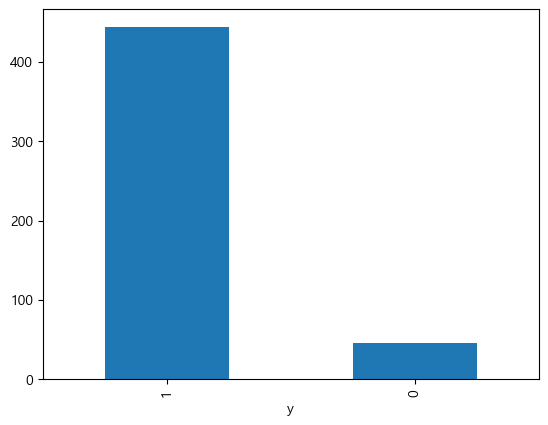

In [22]:
train_df['y'].value_counts().plot(kind = 'bar')

<Axes: xlabel='y'>

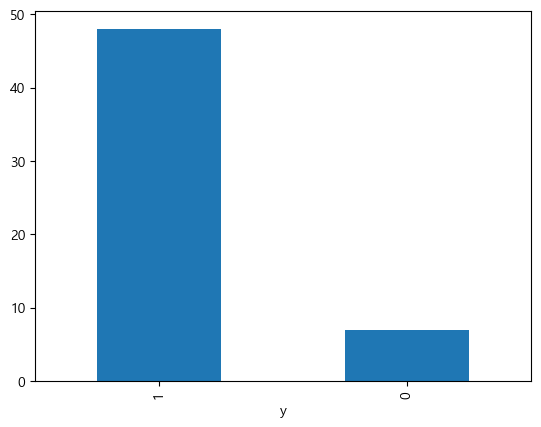

In [23]:
test_df['y'].value_counts().plot(kind = 'bar')

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['review'].tolist())
sequences_train = tokenizer.texts_to_sequences(train_df['review'].tolist())
sequences_test = tokenizer.texts_to_sequences(test_df['review'].tolist())
sequences_train[:5] # 상위 5개 샘플 출력

[[66, 567, 28, 568, 139],
 [569,
  29,
  39,
  570,
  571,
  572,
  9,
  140,
  573,
  574,
  141,
  575,
  576,
  577,
  21,
  578,
  579,
  580,
  581,
  582,
  105,
  208,
  209,
  583,
  584,
  585,
  586,
  587,
  588,
  589],
 [590, 591, 106, 592, 107, 593, 40],
 [108,
  43,
  47,
  594,
  142,
  314,
  67,
  595,
  143,
  33,
  596,
  597,
  598,
  599,
  600,
  105,
  315,
  601,
  7,
  8,
  59,
  602,
  316,
  33,
  144,
  16,
  68,
  603,
  48,
  109,
  11,
  604,
  605,
  606,
  317,
  607,
  318,
  44,
  69,
  608,
  319],
 [15]]

In [25]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print('단어 집합(Vocabulary)의 크기 :',vocab_size)

단어 집합(Vocabulary)의 크기 : 3424


문장의 최대 길이 : 79
문장의 평균 길이 : 11.410204081632653


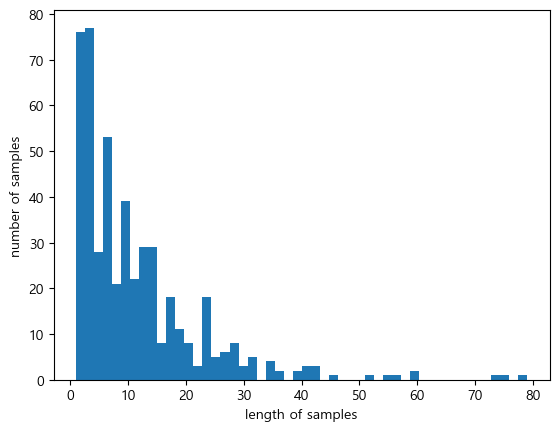

In [26]:
print('문장의 최대 길이 :',max(len(l) for l in sequences_train))
print('문장의 평균 길이 :',sum(map(len, sequences_train))/len(sequences_train))
plt.hist([len(s) for s in sequences_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [27]:
max_len = 80

utterance_train = pad_sequences(sequences_train, maxlen=max_len)
utterance_test = pad_sequences(sequences_test, maxlen=max_len)

label_pos_train = to_categorical(train_df['y'])
label_pos_test = to_categorical(test_df['y'])


print('훈련 데이터의 크기(shape):', utterance_train.shape)
print('훈련 데이터 감정레이블의 크기(shape):', label_pos_train.shape)

훈련 데이터의 크기(shape): (490, 80)
훈련 데이터 감정레이블의 크기(shape): (490, 2)


In [28]:
print('훈련 데이터의 첫번째 샘플 :',utterance_train[0])
print('훈련 데이터의 첫번째 샘플의 감정레이블 :',label_pos_train[0])

훈련 데이터의 첫번째 샘플 : [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0  66 567  28 568 139]
훈련 데이터의 첫번째 샘플의 감정레이블 : [0. 1.]


In [30]:
indices_train = np.arange(utterance_train.shape[0])
np.random.shuffle(indices_train)
print('랜덤 시퀀스 :',indices_train)

indices_test = np.arange(utterance_test.shape[0])
np.random.shuffle(indices_test)

랜덤 시퀀스 : [ 86  29  92 316 409 223 414  20 239 426 141 308  84 145 379 209 489 413
 257  62 265 445 221   7 241 121 375  17 157 451  19 442 420  26 275 332
 183  96 485 115 399 479 286 320 203 400 317 208 350 272 153 289  21 245
 327 135 376 252 311 365 468 184 167 127 471  52 449 273 419 482 274 149
 306  54 199 457 132 315 222 450 102 454  46 230 415 411 470 478 293 182
 277 147 198 389  61  45 339  22  59 304 224 464 324 463  63 336  98 428
 412 171 416 267 421 446 195 116 244  11 418 422 340 406  10  43  58 186
 163  25   6  88  27  53 403 328 120 134 349  60 473 144 436 285 452 155
 358 374 152  97 353 288 486 326  74  36 176 250  31 488 360 427  72 405
 361  48 220 387 129  87 385 312 251 259 440 164 462 119  79  41 106 466
 217 423 123 483  49 280 185 334  16  80 309  35  89 133  34 126  82 329
 455 227 191  40 384 150 125 487 373 122 300  66 438 435 218  99 197  83
 394 111 206 202   1  68 269 476 484 137 356  55 475  32   4 242 276 253
 380 228 333 407 439 323 256 347 248  51 3

In [31]:
X_train = utterance_train[indices_train]
y_pos_train = label_pos_train[indices_train]

X_test = utterance_test[indices_test]
y_pos_test = label_pos_test[indices_test]

In [32]:
embedding_dict = dict()
# 사전 훈련된 Word2Vec 모델을 로드
model = Word2Vec.load(os.path.join(data_dir2, 'ko.bin'))

In [33]:
for word in model.wv.vocab:
    embedding_dict[word] = model.wv[word]
    
print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

30185개의 Embedding vector가 있습니다.


In [34]:
print(embedding_dict['우울'])
print(len(embedding_dict['우울']))

[-1.21498978e+00 -5.43866694e-01  1.32688725e+00 -6.49432898e-01
 -4.38877225e-01  5.52123845e-01  4.83556360e-01  1.02437699e+00
 -2.07902670e-01  1.21977139e+00 -5.29723316e-02  2.83519924e-01
  3.75814110e-01  6.29925787e-01 -5.16617894e-01 -2.62273163e-01
 -1.77138105e-01  7.17207134e-01  1.64666355e-01 -1.71311915e-01
  5.11819899e-01  4.22978140e-02  2.26164639e-01  7.59881958e-02
  3.07586491e-01  6.97090849e-02 -4.44131732e-01  9.51295376e-01
 -9.61420715e-01 -3.31237733e-01  3.33495051e-01 -2.93511562e-02
  4.39231545e-01  2.65127450e-01 -3.65351290e-01 -7.63717890e-01
  7.36222565e-02 -9.49564651e-02  2.45211333e-01  6.11337125e-01
 -1.75878897e-01  6.61108434e-01  1.19337216e-02 -8.98760736e-01
  9.82642323e-02  5.10104120e-01 -3.21627408e-01  2.17479408e-01
  3.48298520e-01  1.51318341e-01 -2.26444125e-01  3.23872238e-01
 -6.18719637e-01  9.16367769e-01 -7.72069275e-01 -2.47000799e-01
 -4.40212220e-01  1.47606462e-01  2.45241672e-01  6.81707561e-01
 -1.40714899e-01  3.91073

In [35]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
print('임베딩 테이블의 크기(shape) :',np.shape(embedding_matrix))


임베딩 테이블의 크기(shape) : (3424, 200)


In [36]:
for word, i in word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [37]:
kernel_sizes = [2, 3, 5]
num_filters = 512
dropout_ratio = 0.5

model_input = Input(shape=(max_len,))
output = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                      input_length=max_len, trainable=False)(model_input)

conv_blocks = []

for size in kernel_sizes:
    conv = Conv1D(filters=num_filters,
                         kernel_size=size,
                         padding="valid",
                         activation="relu",
                         strides=1)(output)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)

output = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
output = Dropout(dropout_ratio)(output)



In [42]:
# Emotion classification model
num_pos_classes = 2
model_output_emotion = Dense(num_pos_classes, activation='softmax')(output)
model_emotion = Model(model_input, model_output_emotion)

model_emotion.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model_emotion.summary()

history_emotion = model_emotion.fit(X_train, y_pos_train,
                                    batch_size=32,
                                    epochs=10,
                                    validation_data=(X_test, y_pos_test))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 80)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 80, 200)              684800    ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 79, 512)              205312    ['embedding[0][0]']           
                                                                                                  
 conv1d_1 (Conv1D)           (None, 78, 512)              307712    ['embedding[0][0]']           
                                                                                            

Epoch 1/10
16/16 [==============================] - 1s 37ms/step - loss: 0.8428 - acc: 0.8327 - val_loss: 1.0397 - val_acc: 0.8182
Epoch 2/10
16/16 [==============================] - 1s 34ms/step - loss: 0.1989 - acc: 0.9490 - val_loss: 1.1781 - val_acc: 0.8545
Epoch 3/10
16/16 [==============================] - 1s 33ms/step - loss: 0.1377 - acc: 0.9653 - val_loss: 1.1807 - val_acc: 0.8545
Epoch 4/10
16/16 [==============================] - 1s 32ms/step - loss: 0.1350 - acc: 0.9714 - val_loss: 1.2290 - val_acc: 0.8545
Epoch 5/10
16/16 [==============================] - 1s 31ms/step - loss: 0.1199 - acc: 0.9673 - val_loss: 1.2123 - val_acc: 0.8545
Epoch 6/10
16/16 [==============================] - 0s 31ms/step - loss: 0.1000 - acc: 0.9714 - val_loss: 1.2143 - val_acc: 0.8364
Epoch 7/10
16/16 [==============================] - 0s 31ms/step - loss: 0.1438 - acc: 0.9653 - val_loss: 1.6419 - val_acc: 0.8909
Epoch 8/10
16/16 [==============================] - 1s 32ms/step - loss: 0.1253 - a

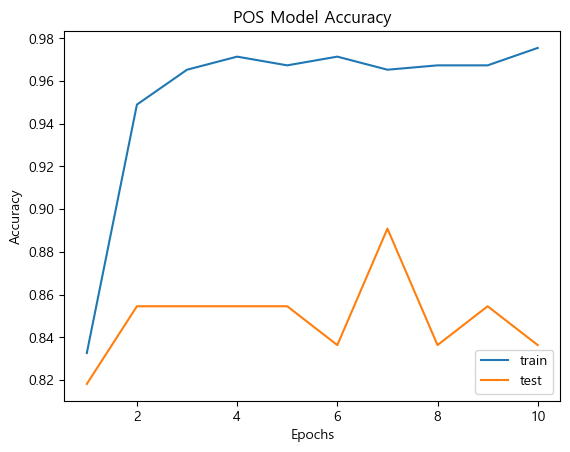

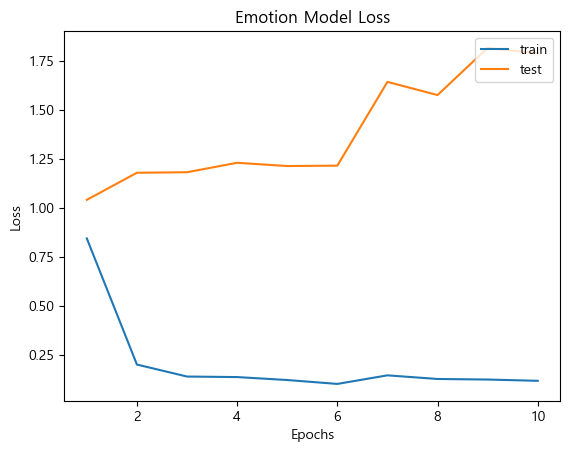

In [43]:
# Plot accuracy and loss graphs for emotion classification
epochs = range(1, len(history_emotion.history['acc']) + 1)
plt.plot(epochs, history_emotion.history['acc'])
plt.plot(epochs, history_emotion.history['val_acc'])
plt.title('POS Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

epochs = range(1, len(history_emotion.history['loss']) + 1)
plt.plot(epochs, history_emotion.history['loss'])
plt.plot(epochs, history_emotion.history['val_loss'])
plt.title('Emotion Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
